<a href="https://colab.research.google.com/github/tripuragorla/CMPE-258-Assignment/blob/main/CMPE_258_Homework_4_Asssignment/CMPE_258_Homework_4_Asssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A: Using Numpy

# Loading Dataset

In [1]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import sys
from keras.datasets import mnist
from matplotlib import pyplot
%matplotlib inline
! pip install -q scikit-plot

(X_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Before Augmentation

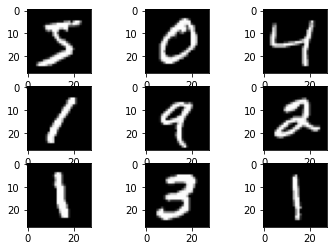

In [2]:
for i in range(0, 9):
		 
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()


# Augment training data

In [3]:
def augment_data(dataset, dataset_labels, augementation_factor=1, use_noise=True, use_random_shear=True, use_random_shift=True, use_scaling=True):
	augmented_image = []
	augmented_image_labels = []

	for num in range (0, dataset.shape[0]):

		for i in range(0, augementation_factor):
			# original image:
			

			transform_image=dataset[num]
			if use_noise:

				transform_image=iaa.AdditiveGaussianNoise(10,20).augment_image(transform_image)


			if use_random_shear:
				transform_image=iaa.Affine(shear=(0,40)).augment_image(transform_image)

			if use_scaling:
				transform_image=iaa.Affine(scale={"x": (1.5, 1.0), "y": (1.5, 1.0)}).augment_image(transform_image)
			augmented_image_labels.append(dataset_labels[num])
			augmented_image.append(transform_image)
	return np.array(augmented_image), np.array(augmented_image_labels)
# augment_data function is called to apply the changes to training data

X_train_aug,y_train_aug=augment_data(X_train,y_train,1,True,True,True,True)

# After Augmentation

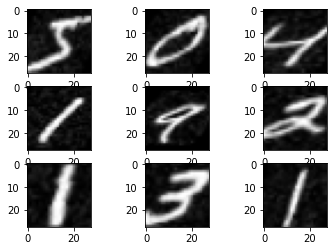

In [4]:
for i in range(0, 9):
		
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_train_aug[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

# Dropout Function

In [5]:
def dropout_mask_create(num_create,percent):
  drop_count=round((num_create/100)*percent)
  index_drop=np.random.permutation(num_create)[:drop_count]
  
  dropout_mask=np.ones(num_create)
  for i in index_drop:
    dropout_mask[i]=0
  return dropout_mask

# Label Transformation

In [6]:
x_train=X_train_aug
images, labels = (x_train[0:x_train.shape[0]].reshape(x_train.shape[0],28*28) / 255, y_train[0:x_train.shape[0]])
test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))
one_hot_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

y_test_true_labels=[None] * y_test.size
y_test_pred_labels=[None] * y_test.size
for i,l in enumerate(y_test):
    test_labels[i][l] = 1

# Configuration parameters - hit and trail method.
#####Learning rate is set to 0.001
#####Number of iterations is set to 15
#####Hidden Layer units
Layer 2 : 50 units
Layer 3 : 100 units
Layer 4 : 150 units

#####Mini Batch Size is set to 8

In [7]:
alpha, iterations, hidden_size1,hidden_size2,hidden_size3,pixels_per_image, num_labels, batch_size = (0.001, 15, 50,100,150, 784, 10,8)

# Relu and its derivative

In [11]:
relu = lambda x:(x>=0) * x # if X > 0 = x & 0 otherwise
derivative = lambda x: x>=0 # if X > 0 = 1 & 0 otherwise

# Initializing Weights for Relu

In [9]:
from math import *
np.random.seed(1)
weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size1)) * sqrt(2.0 / pixels_per_image)
weights_1_2 = 0.2*np.random.random((hidden_size1,hidden_size2)) * sqrt(2.0 / hidden_size1)
weights_2_3 = 0.2*np.random.random((hidden_size2,hidden_size3)) * sqrt(2.0 / hidden_size2)
weights_3_4 = 0.2*np.random.random((hidden_size3,num_labels)) * sqrt(2.0 / hidden_size3)

# Training and Testing

In [12]:
for j in range(iterations):
    error, correct_cnt = (0.0, 0)
    # Forward Propagation in mini batch of 8
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
        layer_0 = images[batch_start:batch_end]
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        dropout_mask=[]
    #Adding dropout of 20 percentage
        for i in range(layer_1.shape[0]):
          dropout_mask.append(dropout_mask_create(layer_1.shape[1],20))
        layer_1 *= dropout_mask
        layer_2 = relu(np.dot(layer_1,weights_1_2))
        layer_3 = relu(np.dot(layer_2,weights_2_3))
        dropout_mask2=[]
    #Adding dropout of 5 percentage
        for i in range(layer_3.shape[0]):
          dropout_mask2.append(dropout_mask_create(layer_3.shape[1],5))
        layer_3 *= dropout_mask2
        layer_4 = np.dot(layer_3,weights_3_4)

        error += np.sum((labels[batch_start:batch_end] - layer_4) ** 2)
        #Backward Propagation in mini batch of 8
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_4[k:k+1]) == np.argmax(labels[batch_start+k:batch_start+k+1]))
            layer_4_delta = (labels[batch_start:batch_end] - layer_4)/batch_size
            layer_3_delta = layer_4_delta.dot(weights_3_4.T)* derivative(layer_3)
            layer_3_delta *= dropout_mask2
            layer_2_delta = layer_3_delta.dot(weights_2_3.T)* derivative(layer_2)

            layer_1_delta = layer_2_delta.dot(weights_1_2.T)* derivative(layer_1)
            layer_1_delta *= dropout_mask
            weights_3_4 += alpha * layer_3.T.dot(layer_4_delta)
            weights_2_3 += alpha * layer_2.T.dot(layer_3_delta)                           
            weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
            weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)  
    if(j >=0):
        test_error = 0.0
        test_correct_cnt = 0
        # Testing for each iteration
        for i in range(len(test_images)):

            layer_0 = test_images[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = relu(np.dot(layer_1,weights_1_2))
            layer_3 = relu(np.dot(layer_2,weights_2_3))
            layer_4 = np.dot(layer_3,weights_3_4)
            test_error += np.sum((test_labels[i:i+1] - layer_4) ** 2)
            y_test_pred_labels[i]=np.argmax(layer_4)
            y_test_true_labels[i]=np.argmax(test_labels[i:i+1])
            test_correct_cnt += int(y_test_pred_labels[i] == \
                                            y_test_true_labels[i])
        # Printing the accuracy to understand the performance  
        sys.stdout.write("\n" + \
                         "I:" + str(j) + \
                         " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
                         " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
                         " Train-Err:" + str(error/ float(len(images)))[0:5] +\
                         " Train-Acc:" + str(correct_cnt/ float(len(images))))
        print()


I:0 Test-Err:0.910 Test-Acc:0.0958 Train-Err:0.936 Train-Acc:0.09133333333333334

I:1 Test-Err:0.909 Test-Acc:0.0958 Train-Err:0.916 Train-Acc:0.09158333333333334

I:2 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.911 Train-Acc:0.09181666666666667

I:3 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.909 Train-Acc:0.09128333333333333

I:4 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.908 Train-Acc:0.09176666666666666

I:5 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.907 Train-Acc:0.09216666666666666

I:6 Test-Err:0.908 Test-Acc:0.0958 Train-Err:0.906 Train-Acc:0.09205

I:7 Test-Err:0.908 Test-Acc:0.1032 Train-Err:0.906 Train-Acc:0.09325

I:8 Test-Err:0.907 Test-Acc:0.1032 Train-Err:0.905 Train-Acc:0.09341666666666666

I:9 Test-Err:0.904 Test-Acc:0.1152 Train-Err:0.904 Train-Acc:0.09815

I:10 Test-Err:0.853 Test-Acc:0.2483 Train-Err:0.843 Train-Acc:0.22595

I:11 Test-Err:1.129 Test-Acc:0.3533 Train-Err:0.744 Train-Acc:0.3378833333333333

I:12 Test-Err:1.085 Test-Acc:0.3672 Train-Err:0.686 Train-Acc:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply



I:16 Test-Err:nan Test-Acc:0.098 Train-Err:nan Train-Acc:0.28696666666666665

I:17 Test-Err:nan Test-Acc:0.098 Train-Err:nan Train-Acc:0.09871666666666666


# Confusion matrix

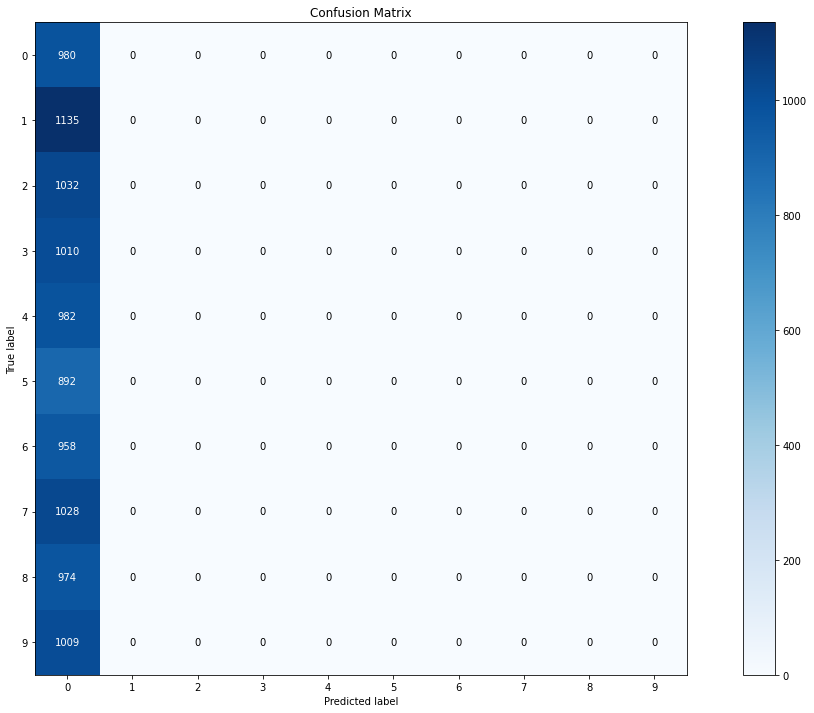

In [13]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test_true_labels, 
    y_test_pred_labels,
    figsize=(20,12))

# Part B : Using Keras

In [14]:
pip install livelossplot

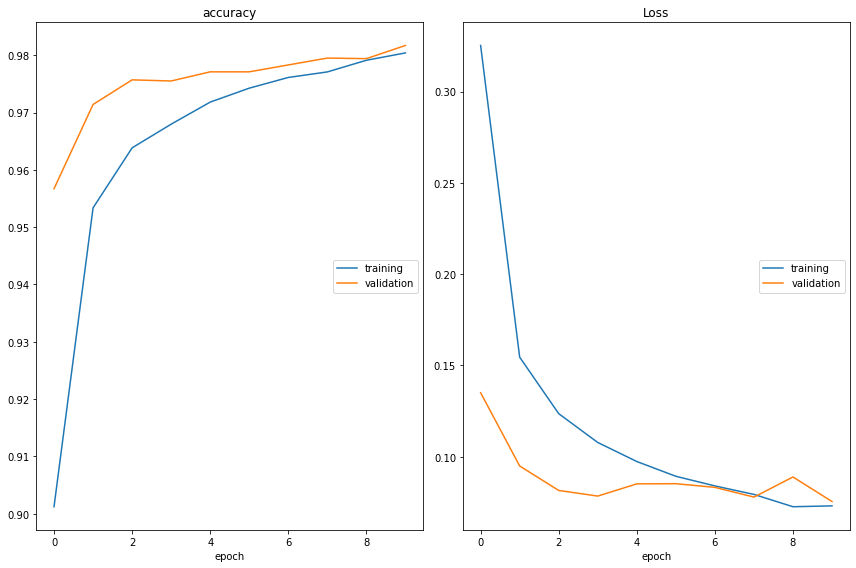

accuracy
	training         	 (min:    0.901, max:    0.980, cur:    0.980)
	validation       	 (min:    0.957, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.073, max:    0.325, cur:    0.073)
	validation       	 (min:    0.076, max:    0.135, cur:    0.076)
Test loss: 0.07551111280918121
Test accuracy: 0.9817000031471252
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________

In [16]:
from keras import models
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

%matplotlib inline

NUM_ROWS = 28
NUM_COLS = 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 10

def data_summary(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)
    print('Train labels:', y_train)
    print('Test labels:', y_test)


"""Load and prepare data"""

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Check state of dataset
data_summary(X_train, y_train, X_test, y_test)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], NUM_ROWS * NUM_COLS))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], NUM_ROWS * NUM_COLS))
X_test = X_test.astype('float32') / 255

# Categorically encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)


"""Build and train neural network"""

# Build neural network
model = models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(NUM_ROWS * NUM_COLS,)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[plot_losses],
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


"""Summarize and visualize the model"""

# Summary of neural network
model.summary()

